<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

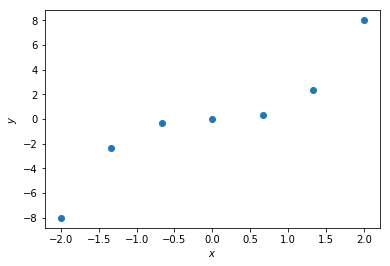

In [72]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

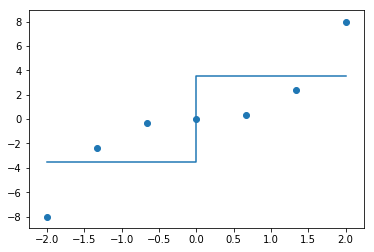

In [73]:
X_l = X[X <= 0]
y_l = [y[X < 0].mean()] * X_l.shape[0]

X_r = X[X >= 0]
y_r = [y[X > 0].mean()] * X_r.shape[0]

y_1 = np.r_[y_l, y_r]
X_1 = np.r_[X_l, X_r]

plt.plot(X_1, y_1)
plt.scatter(X,y)

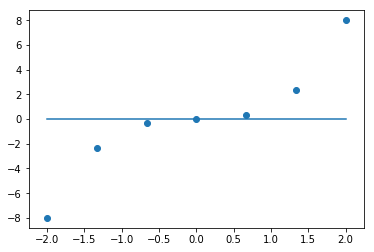

In [74]:
Y=[np.mean(y)]*X.shape[0]
plt.plot(X,Y)
plt.scatter(X,y)
plt.show()

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [75]:
[np.var(X),np.var(X_l), np.var(X_r)]


[1.7777777777777779, 0.55555555555555558, 0.55555555555555547]

In [76]:
def regression_var_criterion(X, y, t):
    pass

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- ## Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [77]:
reg_tree = DecisionTreeRegressor(max_depth=3, random_state=17)

reg_tree.fit(X.reshape(7,1), y)
reg_tree_pred = reg_tree.predict(X)

ValueError: Expected 2D array, got 1D array instead:
array=[-2.         -1.33333337 -0.66666669  0.          0.66666669  1.33333337
  2.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- ## 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [ ]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [ ]:
df.head(5)

Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [ ]:
df['age'] = round(df['age'] / 365.25)
df.head(5)

In [ ]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'])
df.head(5)

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split (df, df['cardio'], test_size= 0.7, random_state= 17)
X_train = X_train.drop(['cardio'], axis= 1)
X_valid = X_valid.drop(['cardio'], axis =1)
dt = DecisionTreeClassifier(max_depth=3, random_state= 17)
dt.fit(X_train, y_train)
# Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [ ]:
export_graphviz(dt, feature_names = X_train.columns, out_file='dt.dot') 
!dot -Tpng dt.dot -o ../../img/hw3_small_tree.png

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- ## age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [ ]:
pred = dt.predict (X_valid)
acc1 = accuracy_score(y_valid, pred)
acc1

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [ ]:
    tree_params = {'max_depth': list(range(2,11))}
    tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5)
    tree_grid.fit(X_train, y_train)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

In [ ]:
tree_grid.cv_results_

In [ ]:
  print ('Best score: %0.6f' % tree_grid.best_score_)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [ ]:
print("Best params:", tree_grid.best_params_)
acc2 = tree_grid.best_score_
print("Best cross validaton score", acc2)

In [ ]:
estimator = tree_grid.best_estimator_

In [79]:
tree_grid.cv_results_['mean_test_score']

array([ 0.71828571,  0.73019048,  0.72914286,  0.72971429,  0.72966667,
        0.72714286,  0.72580952,  0.7192381 ,  0.71538095])

In [91]:
estimator.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 17,
 'splitter': 'best'}

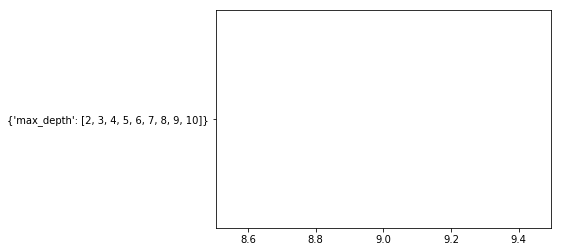

In [96]:
plt.plot (tree_grid.cv_results_['mean_test_score'].shape[0], tree_params)

In [ ]:
learning_curve(estimator, 'title', 'param_grid', cv=5)

In [40]:
tree_grid.grid_scores_

G:\Python\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71829, std: 0.00784, params: {'max_depth': 2},
 mean: 0.73019, std: 0.00723, params: {'max_depth': 3},
 mean: 0.72914, std: 0.00777, params: {'max_depth': 4},
 mean: 0.72971, std: 0.00538, params: {'max_depth': 5},
 mean: 0.72967, std: 0.00737, params: {'max_depth': 6},
 mean: 0.72714, std: 0.00662, params: {'max_depth': 7},
 mean: 0.72581, std: 0.00844, params: {'max_depth': 8},
 mean: 0.71924, std: 0.00647, params: {'max_depth': 9},
 mean: 0.71538, std: 0.00754, params: {'max_depth': 10}]

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

In [41]:
accu_rate = (((acc2 - acc1)/acc1)*100)
print(accu_rate,"%")

0.940397600105 %


In [ ]:
predictions = tree_grid.predict(X_valid)
accuracy_score(y_valid, predictions)

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [47]:
df["age_4550"] = df["age"].apply(lambda x: 1 if x >= 45 and x < 50 else 0)
df["age_5055"] = df["age"].apply(lambda x: 1 if x >= 50 and x < 55 else 0)
df["age_5560"] = df["age"].apply(lambda x: 1 if x >= 55 and x < 60 else 0)
df["age_6065"] = df["age"].apply(lambda x: 1 if x >= 60 and x < 65 else 0)
df["ap_hi_120140"] = df["ap_hi"].apply(lambda x: 1 if x >= 120 and x < 140 else 0)
df["ap_hi_140160"] = df["ap_hi"].apply(lambda x: 1 if x >= 140 and x < 160 else 0)
df["ap_hi_160180"] = df["ap_hi"].apply(lambda x: 1 if x >= 160 and x < 180 else 0)
df['gender'].replace([1,2],['0','1'], inplace=True)
df['male'] = df['gender']


In [50]:
df.drop(['gluc_1', 'gluc_2', 'gluc_3', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'alco'], axis = 1, inplace=True)

In [51]:
df.head(5)

,smoke,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,age_4550,age_5055,age_5560,age_6065,ap_hi_120140,ap_hi_140160,ap_hi_160180,male
id,,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
1,0,1,1,0,0,1,0,0,1,0,0,1,0,0
2,0,0,1,0,0,1,0,1,0,0,1,0,0,0
3,0,1,1,1,0,0,1,0,0,0,0,1,0,1
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [ ]:
df['age_5560'].value_counts()

In [ ]:
df['ap_hi_140160'].value_counts()

In [52]:
df['ap_hi_120140'].value_counts()

1    37561
0    32439
Name: ap_hi_120140, dtype: int64

In [53]:
df['ap_hi_160180'].value_counts()

0    66099
1     3901
Name: ap_hi_160180, dtype: int64

In [54]:
X_last= df.drop(['cardio'], axis= 1)
dtt = DecisionTreeClassifier(max_depth=3, random_state= 17)
dtt.fit(X_last, df['cardio'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [55]:
dtt.feature_importances_

array([  5.36170201e-05,   0.00000000e+00,   0.00000000e+00,
         4.37410163e-04,   1.69891434e-01,   0.00000000e+00,
         1.11066778e-04,   3.19214730e-04,   0.00000000e+00,
         0.00000000e+00,   5.80596608e-01,   2.48590650e-01,
         0.00000000e+00])

In [ ]:
export_graphviz(dtt, feature_names = X_last.columns, out_file='binariezz.dot') 
!dot -Tpng binariezz.dot -o ../../img/binariezz.png

In [56]:
imp = dtt.feature_importances_

In [65]:
indices = np.argsort(imp)[::-1]

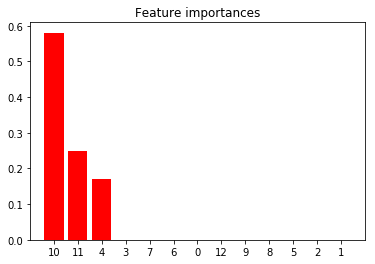

In [69]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_last.shape[1]), imp[indices],
       color="r", align="center")
plt.xticks(range(X_last.shape[1]), indices)
plt.xlim([-1, X_last.shape[1]])
plt.show()